# VAR(p) processes
We are interested in modeling a T×K multivariate time series Y, where T denotes the number of observations and K the number of variables. One way of estimating relationships between the time series and their lagged values is the vector autoregression process:




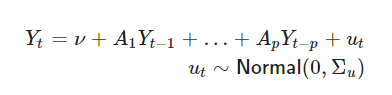

where Ai is a K×K coefficient matrix.

# Model fitting

To estimate a VAR model, one must first create the model using an ndarray of homogeneous or structured dtype. When using a structured or record array, the class will use the passed variable names. Otherwise they can be passed explicitly:

In [0]:
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Import Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

import plotly.offline as pyoff
import plotly.graph_objs as go

# Import the datasets

In [0]:
mdata = pd.read_csv("COVID-19.csv", header=0)
 
df = pd.DataFrame(mdata, columns= ['Cases','Dealth'])

print(mdata)
df.shape

      Date  Cases  Dealth
0   19-Feb     27       0
1   20-Feb     53       1
2   21-Feb     98       1
3   22-Feb    227       0
4   23-Feb    166       4
5   24-Feb    231       2
6   25-Feb    144       3
7   26-Feb    284       1
8   27-Feb    505       1
9   28-Feb    571       3
10  29-Feb    813       1
11  01-Mar    586       4
12  02-Mar    599       7
13  03-Mar    851       4
14  04-Mar    435       3
15  05-Mar    663       7
16  06-Mar    309       1
17  07-Mar    448       5
18  08-Mar    272       2
19  09-Mar    165       3
20  10-Mar     35       7
21  11-Mar    242       0
22  12-Mar    114       6
23  13-Mar    110       1
24  14-Mar    167       5
25  15-Mar     76       3
26  16-Mar     74       0
27  17-Mar     84       6
28  18-Mar     93       3
29  19-Mar    157       7
30  20-Mar     87       3
31  21-Mar    147       8
32  22-Mar     78       2
33  23-Mar     64       7
34  24-Mar     76       9
35  25-Mar    100       6


(36, 2)

The VAR class assumes that the passed time series are stationary. Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method. For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate.

Visualize the Time Series

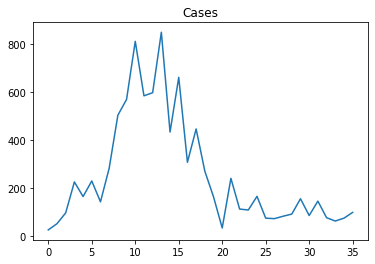

In [0]:
mdata['Cases'].plot(title = 'Cases')

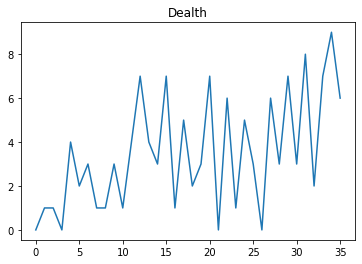

In [0]:
mdata['Dealth'].plot(title = 'Dealth')

In [0]:
#plot Daily Cases
plot_data = [
    go.Scatter(
        x=mdata['Date'],
        y=mdata['Cases'],
    )
]
plot_layout = go.Layout(
        title='Daily Cases'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
#plot Daily Dealth
plot_data = [
    go.Scatter(
        x=mdata['Date'],
        y=mdata['Dealth'],
    )
]
plot_layout = go.Layout(
        title='Daily Dealth'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
from statsmodels.tsa.base.datetools import dates_from_str

mdata = mdata[['Cases', 'Dealth']]


#data = np.log(mdata).diff().dropna()

# make a VAR model
model = VAR(mdata)

In [0]:
results = model.fit(2)

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Apr, 2020
Time:                     08:45:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.2509
Nobs:                     34.0000    HQIC:                   11.9550
Log likelihood:          -287.121    FPE:                    134086.
AIC:                      11.8019    Det(Omega_mle):         101909.
--------------------------------------------------------------------
Results for equation Cases
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            97.614747        60.321898            1.618           0.106
L1.Cases          0.402861         0.162267            2.483           0.013
L1.Dealth        -7.077254         9.235303           -0.766           0.443

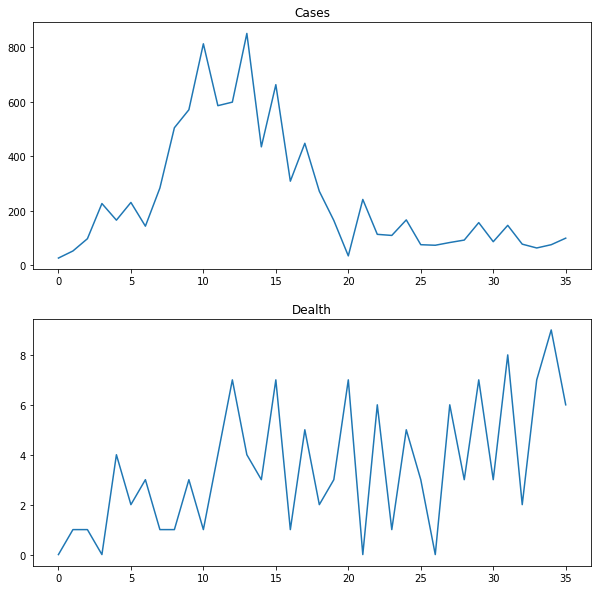

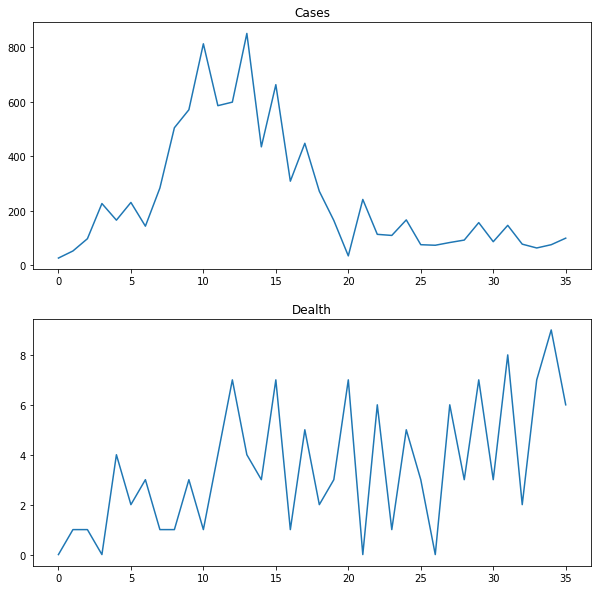

In [0]:
results.plot()

### Lag order selection¶
Choice of lag order can be a difficult problem. Standard analysis employs likelihood test or information criteria-based order selection. We have implemented the latter, accessible through the VAR class:

In [0]:
model.select_order(10)

When calling the fit function, one can pass a maximum number of lags and the order criterion to use for order selection:

In [0]:
results = model.fit(maxlags=10, ic='aic')

# Forecasting
The linear predictor is the optimal h-step ahead forecast in terms of mean-squared error:

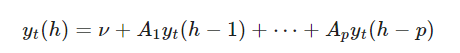

We can use the forecast function to produce this forecast. Note that we have to specify the “initial value” for the forecast:

In [0]:
lag_order = results.k_ar

In [0]:
results.forecast(mdata.values[-lag_order:], 5)

array([[-269.86939953,   13.82910835],
       [-224.13737765,    8.60861986],
       [-548.78753057,   12.53081193],
       [-693.49028188,   10.59750473],
       [-835.53185204,   12.10218542]])

The forecast_interval function will produce the above forecast along with asymptotic standard errors. These can be visualized using the plot_forecast function:

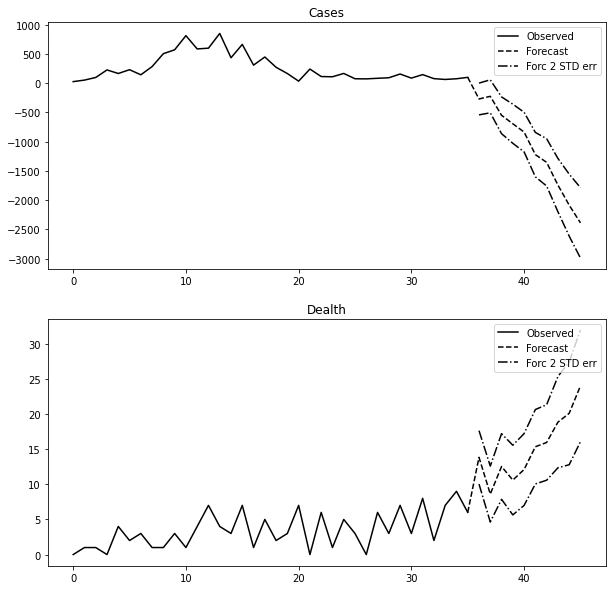

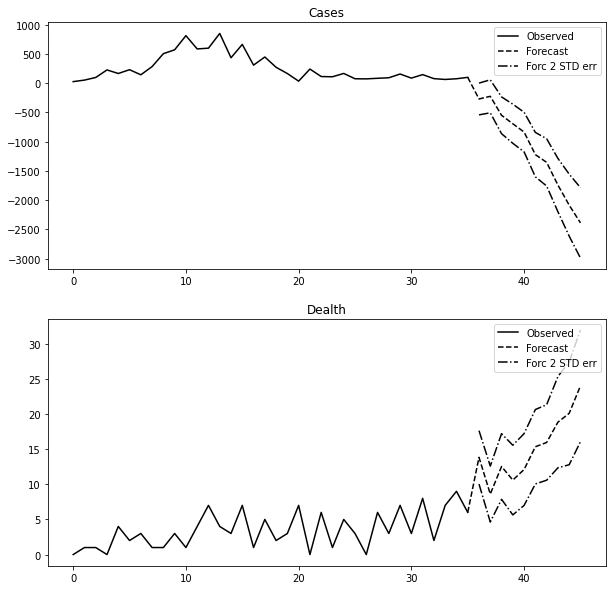

In [0]:
results.plot_forecast(10)

# Impulse Response Analysis¶

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables. They are computed in practice using the MA(∞) representation of the VAR(p) process:

Yt=μ+∑i=0∞Φiut−i

We can perform an impulse response analysis by calling the irf function on a VARResults object:

In [0]:
irf = results.irf(10)

These can be visualized using the plot function, in either orthogonalized or non-orthogonalized form. Asymptotic standard errors are plotted by default at the 95% significance level, which can be modified by the user.

Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix Σ^u and hence interpretations may change depending on variable ordering.

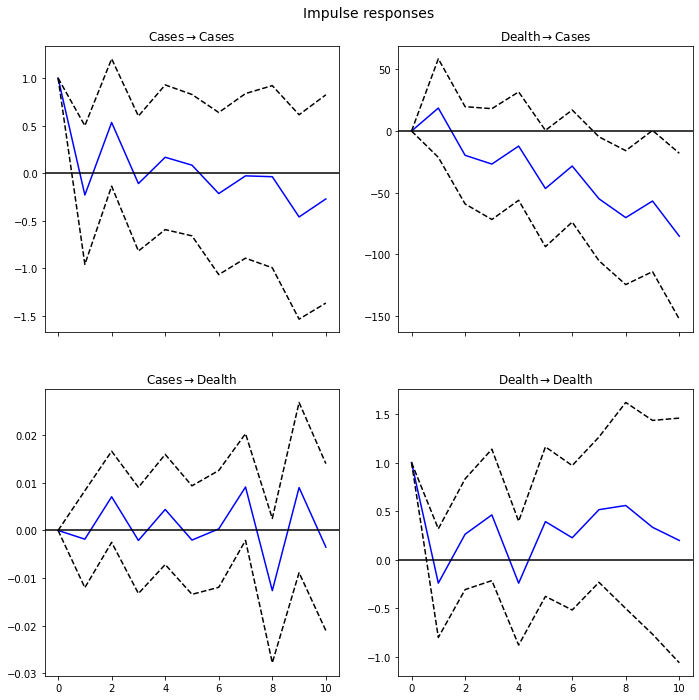

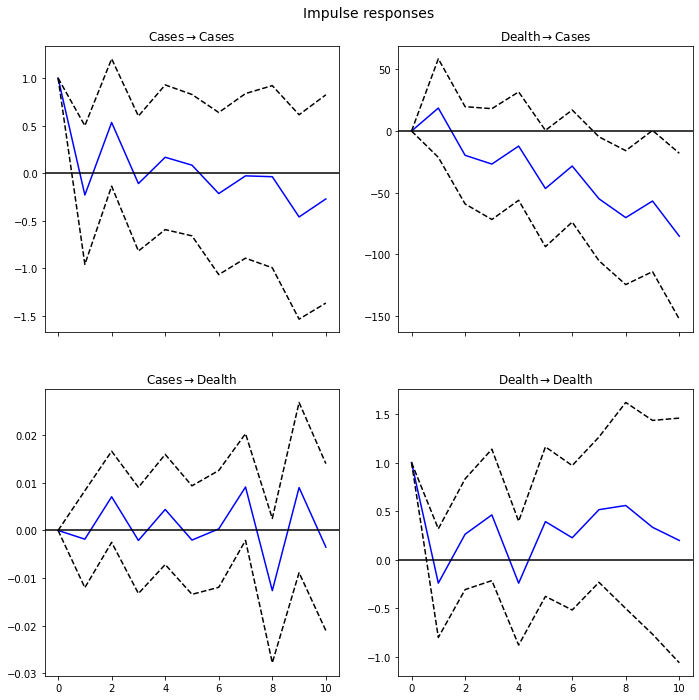

In [0]:
irf.plot(orth=False)

It should be noted that  the plot function is flexible and can plot only variables of interest if so desired:

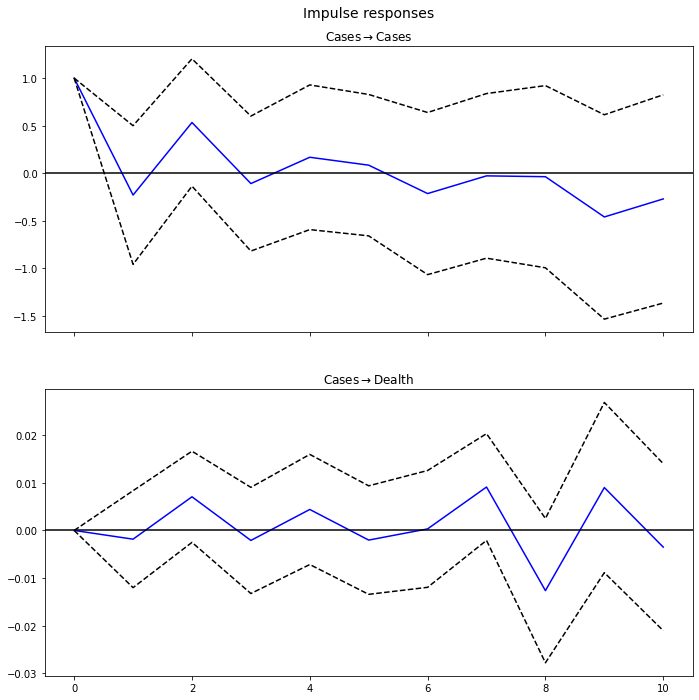

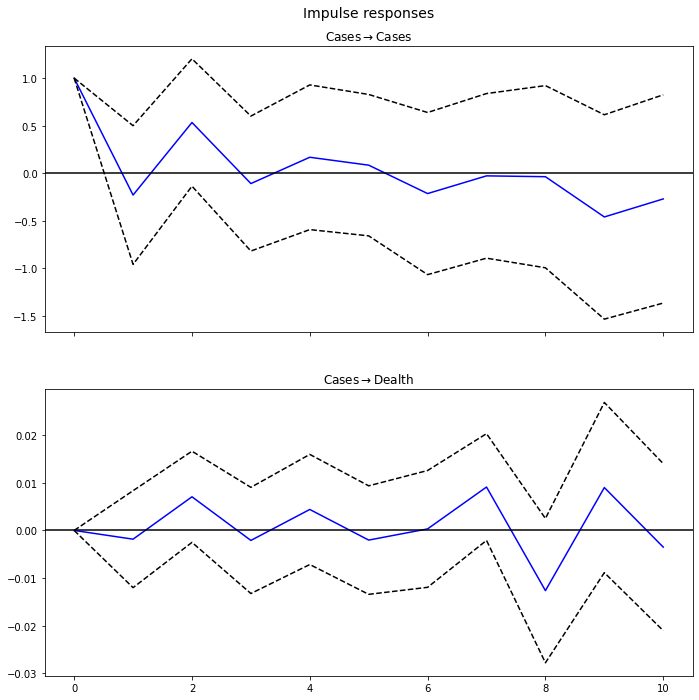

In [0]:
irf.plot(impulse='Cases')

The cumulative effects 
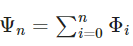Ψn=∑ni=0Φi 
can be plotted with the long run effects as follows:

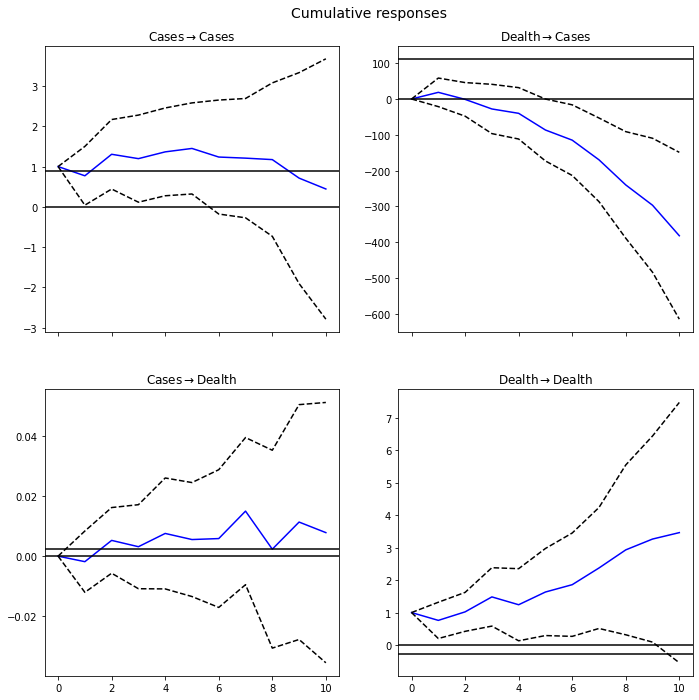

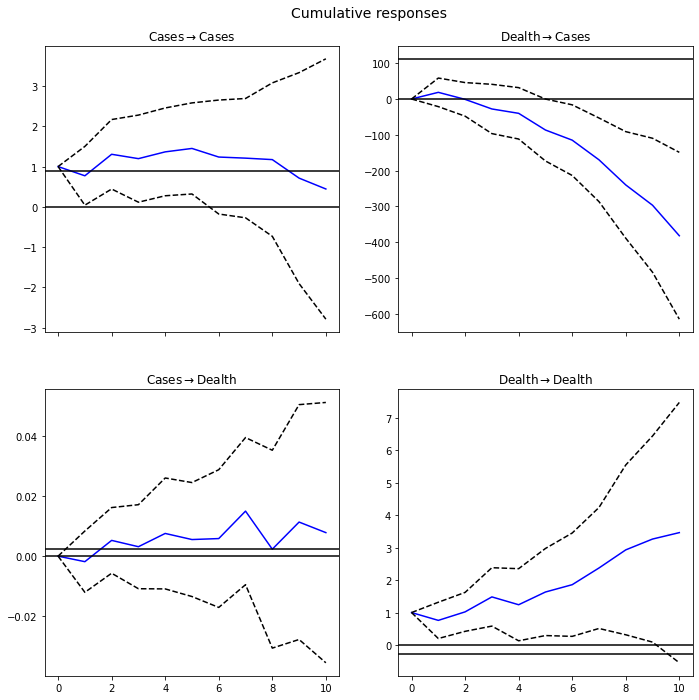

In [0]:
irf.plot_cum_effects(orth=False)

# Forecast Error Variance Decomposition (FEVD)

Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses Θi

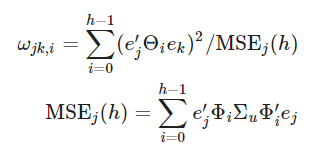

These are computed via the fevd function up through a total number of steps ahead:

In [0]:
fevd = results.fevd(5)

In [0]:
fevd.summary()

FEVD for Cases
        Cases    Dealth
0    1.000000  0.000000
1    0.944344  0.055656
2    0.905120  0.094880
3    0.834625  0.165375
4    0.822086  0.177914

FEVD for Dealth
        Cases    Dealth
0    0.116868  0.883132
1    0.148158  0.851842
2    0.341969  0.658031
3    0.304202  0.695798
4    0.316423  0.683577




They can also be visualized through the returned FEVD object:

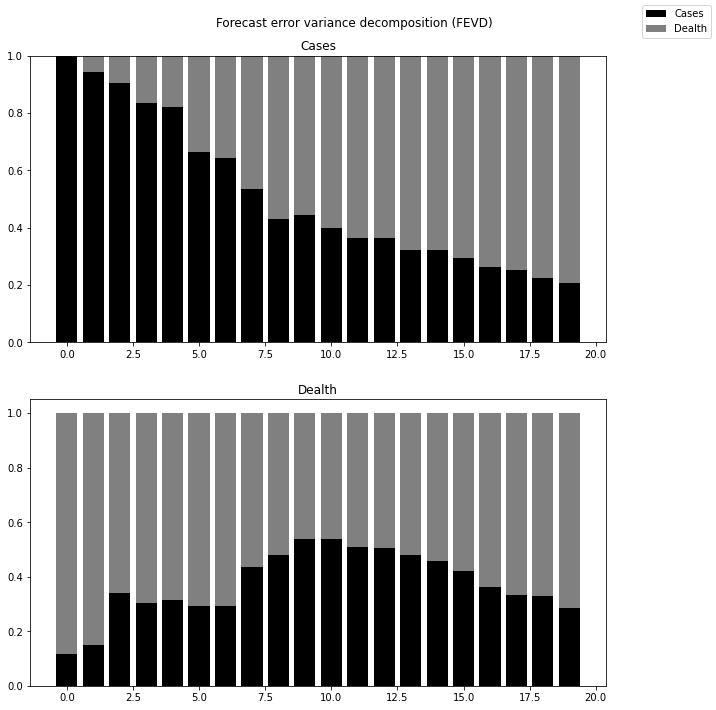

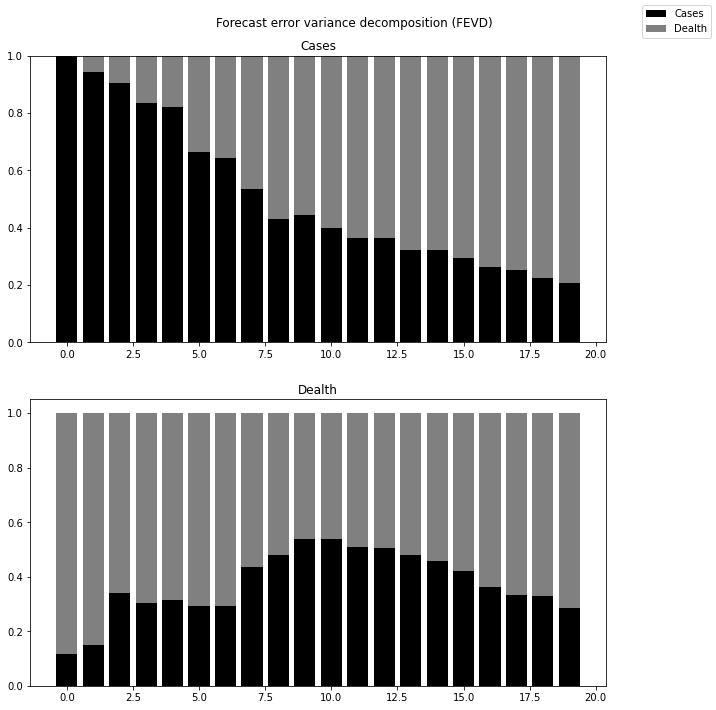

In [0]:
results.fevd(20).plot()

# Statistical tests
A number of different methods are provided to carry out hypothesis tests about the model results and also the validity of the model assumptions (normality, whiteness / “iid-ness” of errors, etc.).

# Granger causality
One is often interested in whether a variable or group of variables is “causal” for another variable, for some definition of “causal”. In the context of VAR models, one can say that a set of variables are Granger-causal within one of the VAR equations. The VARResults object has the test_causality method for performing either a Wald (χ2) test or an F-test.

In [0]:
results.test_causality('Cases', ['Dealth'], kind='f')